### 基于时序差分（Temporal Difference，TD）

- 无需环境模型
- 单步学习
- 方差低于 Monte Corlo

对状态价值函数 $V(s)$ 的增量更新：

$$
V(s_t) \leftarrow V(s_t) + \alpha \underbrace{\left[ r_{t+1} + \gamma V(s_{t+1}) - V(s_t) \right]}_{\text{TD error } \delta_t}
$$

其中：
- $\delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)$：**TD 误差**
- $\alpha \in (0,1]$：学习率
- $\gamma \in [0,1]$：折扣因子

> 📌 **对比**：
> - MC：使用完整回报 $G_t = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k+1}$
> - TD(0)：使用 **1-step return**：$r_{t+1} + \gamma V(s_{t+1})$

主要TD算法：`SARSA`、`Q-Learning`、`TD(λ)`  
其中，`SARSA`、`Q-Learning`区别在于是否是在线策略  
> 我们称采样数据的策略为`行为策略（behavior policy）`，称用这些数据来更新的策略为`目标策（target policy）`。  
> 在线策略（on-policy）算法表示行为策略和目标策略是同一个策略；而离线策略（off-policy）算法表示行为策略和目标策略不是同一个策略。  

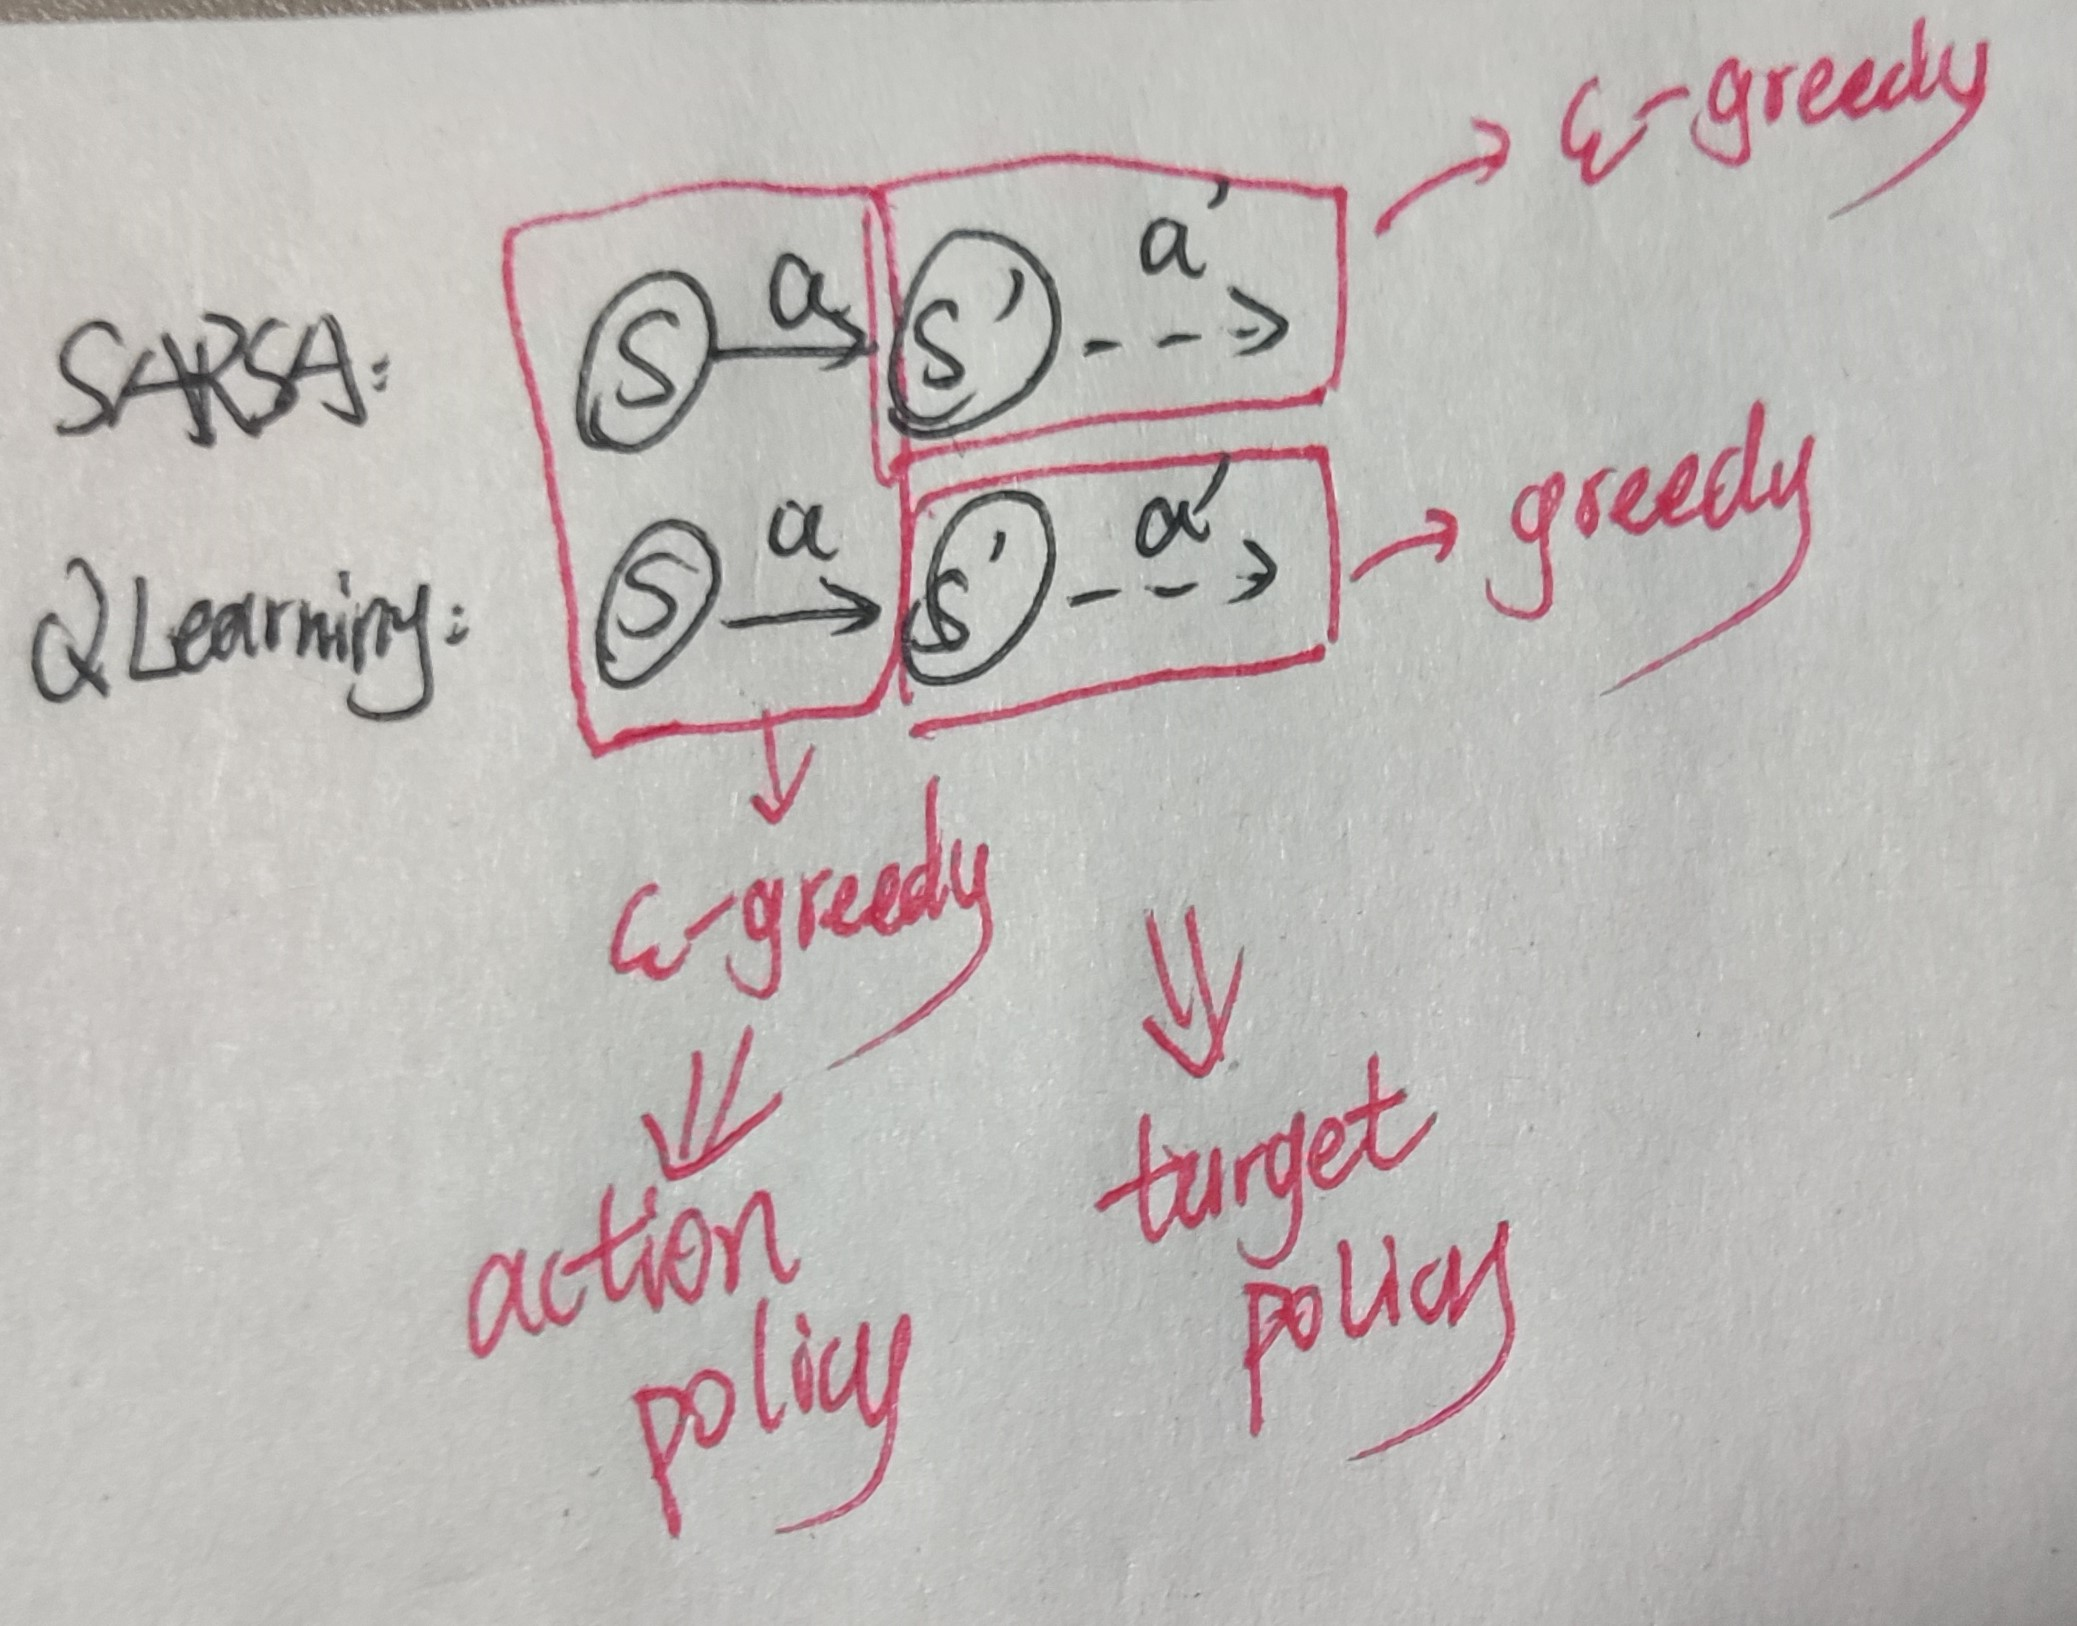

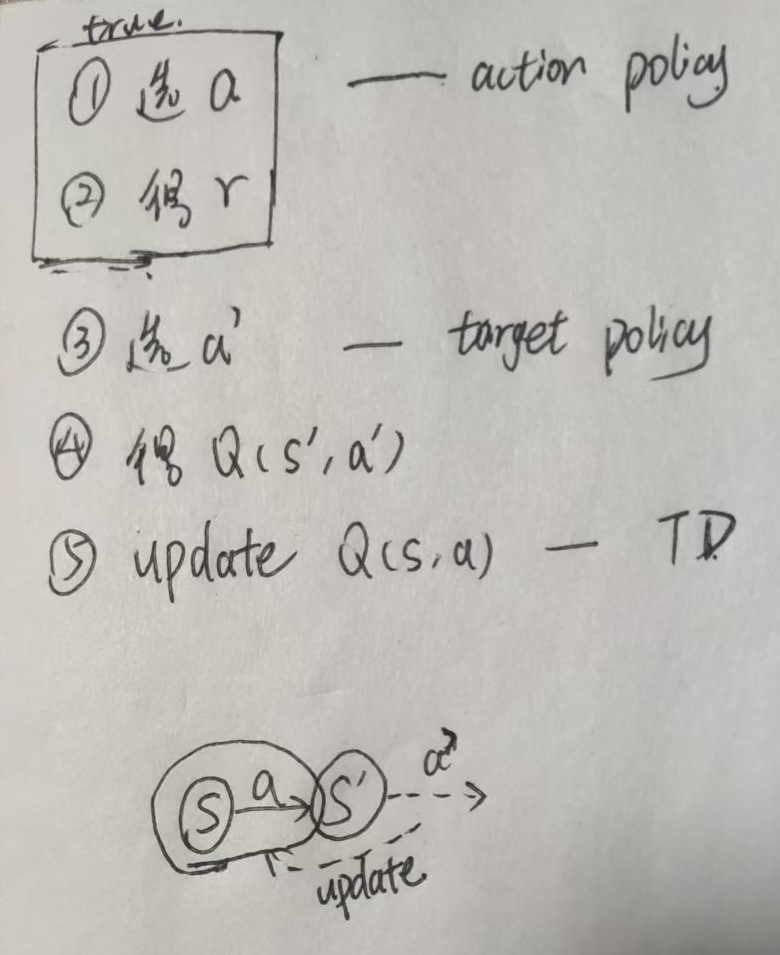

### SARSA

- 在线策略：
  在线策略（on-policy）算法表示行为策略和目标策略是同一个策略

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \Big[ \underbrace{r_{t+1}}_{\text{reward}} + \gamma \underbrace{Q(s_{t+1}, a_{t+1})}_{\text{next Q (from behavior policy)}} - Q(s_t, a_t) \Big]
$$

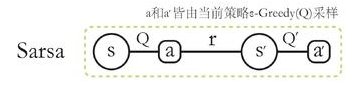


In [ ]:
class SARSA(RL_Model):
  '''
    SARSA：不需要环境数据（MDP）
  '''
  def __init__(self, env:ENV_INFO, epsilon, alpha, gamma):
    super().__init__()
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon

    self.Q = np.zeros((env._states_num, env._actions_num))
    self.pi = np.zeros([env._states_num, env._actions_num])

  def take_action(self, state):
    argmax_action = np.argmax(self.Q[state])
    return RTools_epsilon(self.epsilon, self.env._actions_num, argmax_action)
  
  def update(self, s0, a0, r, s1, a1):
    td_error = r+self.gamma*self.Q[s1, a1]-self.Q[s0, a0]
    self.Q[s0, a0] += self.alpha*td_error

  def get_policy(self):
    for state in range(self.env._states_num):
      maxQ = np.max(self.Q[state])
      for i in range(self.env._actions_num):
        if self.Q[state, i] == maxQ:
          self.pi[state, i] = 1

  def run(self, episodes=50):
    for episode in range(episodes):
      state, _ = self.env.reset()
      action = self.take_action(state)
      done = False
      while not done:
        n_state, reward, done, _ = self.env.step(action)
        # if hasattr(self.env, 'render'):
        #   self.env.render()
        n_action = self.take_action(n_state)
        self.update(state, action, reward, n_state, n_action)
        state, action = n_state, n_action
    self.get_policy()

class SARSA_nstep(RL_Model):
  '''
    nSteps SARSA
  '''
  def __init__(self, env:ENV_INFO, n_steps, epsilon, alpha, gamma):
    super().__init__()
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.n_steps = n_steps

    self.Q = np.zeros((env._states_num, env._actions_num))
    self.pi = np.zeros([env._states_num, env._actions_num])
    self.state_list = []
    self.action_list = []
    self.reward_list = []

  def take_action(self, state):
    argmax_action = np.argmax(self.Q[state])
    return RTools_epsilon(self.epsilon, self.env._actions_num, argmax_action)
  
  def update(self, s0, a0, r, s1, a1, done):
    self.state_list.append(s0)
    self.action_list.append(a0)
    self.reward_list.append(r)
    if len(self.state_list) == self.n_steps:
      G = self.Q[s1, a1]
      for i in reversed(range(self.n_steps)):
        G = G*self.gamma+self.reward_list[i]
        if done and i > 0:
          s = self.state_list[i]
          a = self.action_list[i]
          self.Q[s, a] += self.alpha*(G-self.Q[s, a])
      s = self.state_list.pop(0)
      a = self.action_list.pop(0)
      self.reward_list.pop(0)
      self.Q[s, a] += self.alpha*(G-self.Q[s, a])
    if done:
      self.state_list = []
      self.action_list = []
      self.reward_list = []

  def get_policy(self):
    for state in range(self.env._states_num):
      maxQ = np.max(self.Q[state])
      for i in range(self.env._actions_num):
        if self.Q[state, i] == maxQ:
          self.pi[state, i] = 1

  def run(self, episodes=50):
    for episode in range(episodes):
      state, _ = self.env.reset()
      action = self.take_action(state)
      done = False
      while not done:
        n_state, reward, done, _ = self.env.step(action)
        n_action = self.take_action(n_state)
        self.update(state, action, reward, n_state, n_action, done)
        state, action = n_state, n_action
    self.get_policy()


### Q-Learning

- 离线策略：
  离线策略（off-policy）算法表示行为策略和目标策略不是同一个策略。

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \Big[ \underbrace{r_{t+1}}_{\text{reward}} + \gamma \underbrace{\max_{a} Q(s_{t+1}, a)}_{\text{greedy next Q}} - Q(s_t, a_t) \Big]
$$

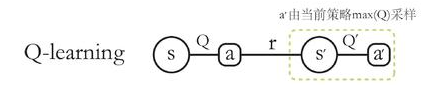


In [ ]:
class Q_Learning(RL_Model):
  def __init__(self, env:ENV_INFO, epsilon, alpha, gamma):
    super().__init__()
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon

    self.Q = np.zeros((env._states_num, env._actions_num))
    self.pi = np.zeros((env._states_num, env._actions_num))

  def take_action(self, state):
    argmax_action = np.argmax(self.Q[state])
    return RTools_epsilon(self.epsilon, self.env._actions_num, argmax_action)
  
  def update(self, s0, a0, r, s1):
    td_error = r+self.gamma*self.Q[s1].max()-self.Q[s0, a0]
    self.Q[s0, a0] += self.alpha*td_error

  def get_policy(self):
    for state in range(self.env._states_num):
      maxQ = np.max(self.Q[state])
      for i in range(self.env._actions_num):
        if self.Q[state, i] == maxQ:
          self.pi[state, i] = 1

  @utils_timer
  def run(self, episodes=50):
    for episode in range(episodes):
      state, _ = self.env.reset()
      done = False
      while not done:
        action = self.take_action(state)
        n_state, reward, done, _ = self.env.step(action)
        self.update(state, action, reward, n_state)
        state = n_state
    self.get_policy()

> 问题：
  如果Q只增不减，α是不是可以直接等于1了，极大提高训练速度。

### Dyna-Q
  一种思想方式...😕

- Model Based （不同于SARSA QLearning）

- 核心思想：智能体在与真实环境交互的同时，在线构建一个内部环境模型，并利用这个模型生成“想象出来的”（即模拟的）经验，反复进行规划（planning），实现了“一次真实交互，多次学习更新”。

- 步骤：

  1. 智能体在真实环境中执行一步动作，观察到状态转移 (s, a) → (r, s')。它首先像标准 Q-learnin 一样，用这一个真实样本去更新 Q 表，这个过程称为 direct RL update 或 Q-learning step。

  2. 在获得一个真实经验后，智能体会立即将其 (s, a) 与结果 (r, s') 存入一个内部模型（Model） 中。

  3. 算法会进行 n_planning 次“想象”式的模拟学习。它从模型中随机抽取一个之前存储的经验（状态-动作对 (s, a) 及其 (r, s')），然后再次像 Q-learning 一样，用这个“假想”的经验去更新 Q 表。这个过程称为 Q-planning。


In [ ]:
class Dyna_Q(RL_Model):
  def __init__(self, env:ENV_INFO, epsilon, alpha, gamma, n_planning):
    super().__init__()
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.n_planning = n_planning
    self.model = dict()     # 脑内模拟库

    self.Q = np.zeros((env._states_num, env._actions_num))
    self.pi = np.zeros((env._states_num, env._actions_num))

  def take_action(self, state):
    argmax_action = np.argmax(self.Q[state])
    return RTools_epsilon(self.epsilon, self.env._actions_num, argmax_action)
  
  def q_learning(self, s0, a0, r, s1):
    td_error = r+self.gamma*self.Q[s1].max()-self.Q[s0, a0]
    self.Q[s0, a0] += self.alpha*td_error

  def update(self, s0, a0, r, s1):
    self.q_learning(s0, a0, r, s1)
    self.model[(s0, a0)] = r, s1
    for _ in range(self.n_planning):
      (s, a), (r, s_) = random.choice(list(self.model.items()))
      self.q_learning(s, a, r, s_)

  def get_policy(self):
    for state in range(self.env._states_num):
      maxQ = np.max(self.Q[state])
      for i in range(self.env._actions_num):
        if self.Q[state, i] == maxQ:
          self.pi[state, i] = 1
    return self.pi

  @utils_timer
  def run(self, episodes=None, diff_tol=1e-6, quit_cnt=5):
    '''
      params:
        episodes - 
          None时，提前停止，使用 diff_tol quit_cnt 参数
          int时，固定训练 episodes 轮数，不使用 diff_tol quit_cnt 参数
        diff_tol: float - 当 差异 大于 diff_tol 时，退出计数+1
        quit_cnt: int - 退出计数，当退出计数达到 quit_cnt 时，提前停止
    '''
    if episodes is not None:
      for episode in range(episodes):
        state, _ = self.env.reset()
        done = False
        while not done:
          action = self.take_action(state)
          n_state, reward, done, _ = self.env.step(action)
          self.update(state, action, reward, n_state)
          state = n_state
    else:
      times, cnt = 0, 0
      while True:
        times += 1
        last_Q = self.Q.copy()
        state, _ = self.env.reset()
        done = False
        while not done:
          action = self.take_action(state)
          n_state, reward, done, _ = self.env.step(action)
          self.update(state, action, reward, n_state)
          state = n_state
        current_Q = self.Q.copy()
        Q_diff = np.abs(current_Q-last_Q).sum()
        # print(f'Q Δ = {Q_diff:.6f}')
        if Q_diff < diff_tol:
          cnt += 1
          if cnt > quit_cnt:
            print(f'Finished after {times} times.')
            break
        else:
          cnt = 0
    self.get_policy()
